In [1]:
%load_ext zipline
%load_ext watermark
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

from collections import OrderedDict
import pytz

# необходимые функции zipline
from zipline.api import (order, record, symbol, set_benchmark, order_target_percent, get_open_orders, order_target, 
                        schedule_function, date_rules, time_rules, order_percent, symbols)
# комиссии
from zipline.finance import commission

# выбор календаря по которому происходит торговля
from trading_calendars.always_open import AlwaysOpenCalendar

import zipline

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime, date

# aинансовые данные
from yahoofinancials import YahooFinancials

# отчёт
import pyfolio as pf

# import helper functions 
import qf_helper_functions as qf

import pypfopt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

import pylab

from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import style
from matplotlib import mlab
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.ticker as mtick
%matplotlib inline

plt.style.use('default')
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 200

#векторный формат
%config InlineBackend.figure_format = 'svg'

from tqdm import tqdm

# Прогружаем данные

In [3]:
def download_csv_data(ticker, start_date, end_date, freq, path):
    
    yahoo_financials = YahooFinancials(ticker)

    df = yahoo_financials.get_historical_price_data(start_date, end_date, freq)
    df = pd.DataFrame(df[ticker]['prices']).drop(['date'], axis=1) \
            .rename(columns={'formatted_date':'date'}) \
            .loc[:, ['date','open','high','low','close', 'adjclose', 'volume']] \
            .set_index('date')
    df.index = pd.to_datetime(df.index)
    df['dividend'] = 0
    df['split'] = 1

    # save data to csv for later ingestion
    df.to_csv(path, header=True, index=True)

    # plot the time series
    df.close.plot(title='{} prices --- {}:{}'.format(ticker, start_date, end_date), color='green', fontsize=8);

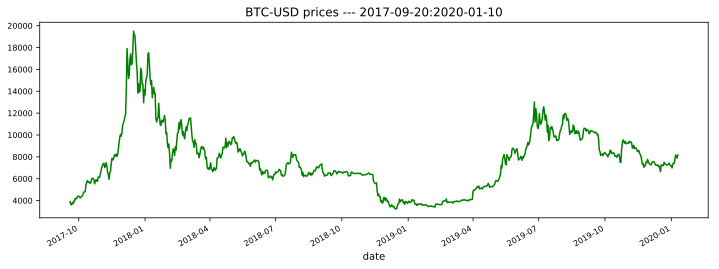

In [4]:
download_csv_data(ticker='BTC-USD', 
                  start_date='2017-09-20', 
                  end_date='2020-01-10', 
                  freq='daily', 
                  path='data/BTC.csv')

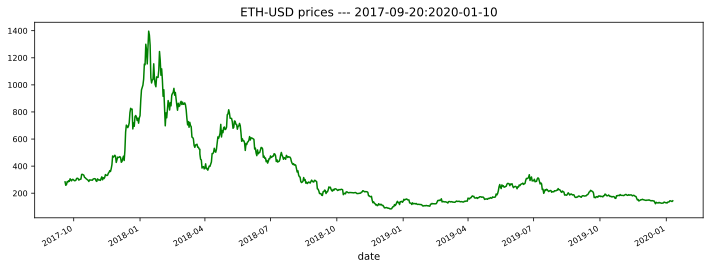

In [5]:
download_csv_data(ticker='ETH-USD', 
                  start_date='2017-09-20', 
                  end_date='2020-01-10', 
                  freq='daily', 
                  path='data/ETH.csv')

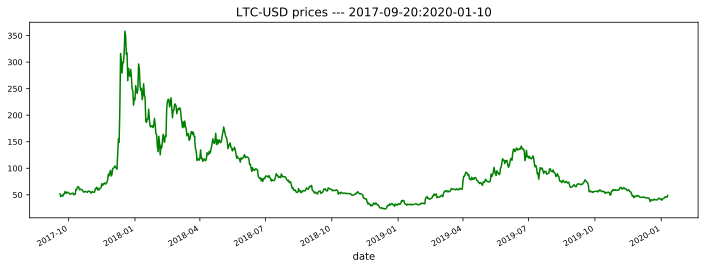

In [6]:
download_csv_data(ticker='LTC-USD', 
                  start_date='2017-09-20', 
                  end_date='2020-01-10', 
                  freq='daily', 
                  path='data/LTC.csv')

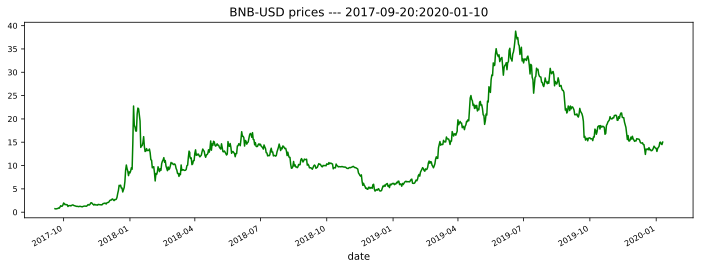

In [7]:
download_csv_data(ticker='BNB-USD', 
                  start_date='2017-09-20', 
                  end_date='2020-01-10', 
                  freq='daily', 
                  path='data/BNB.csv')

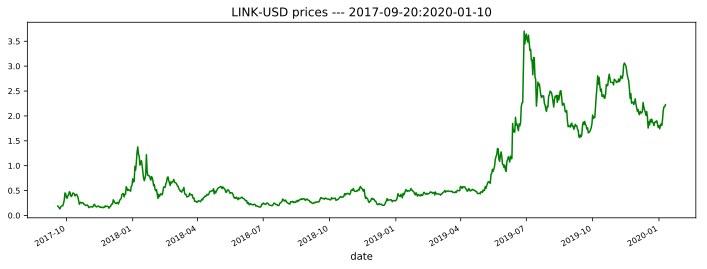

In [8]:
download_csv_data(ticker='LINK-USD', 
                  start_date='2017-09-20', 
                  end_date='2020-01-10', 
                  freq='daily', 
                  path='data/LINK.csv')

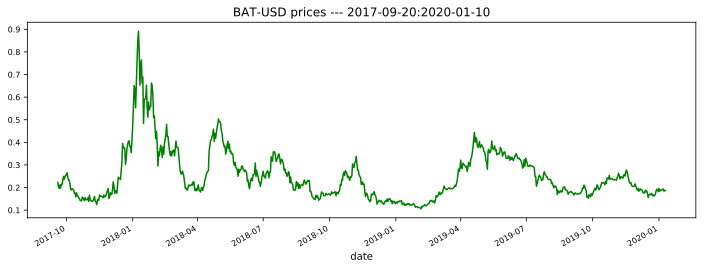

In [9]:
download_csv_data(ticker='BAT-USD', 
                  start_date='2017-09-20', 
                  end_date='2020-01-10', 
                  freq='daily', 
                  path='data/BAT.csv')

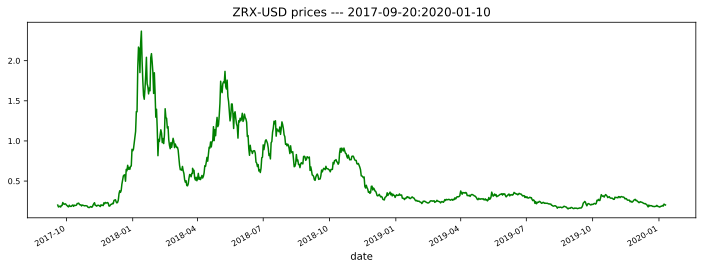

In [10]:
download_csv_data(ticker='ZRX-USD', 
                  start_date='2017-09-20', 
                  end_date='2020-01-10', 
                  freq='daily', 
                  path='data/ZRX.csv')

In [11]:
# Список финансовых инструментов в портфеле
TIKERS = ['BTC', 'ETH', 'LTC', 'BNB', 'LINK', 'BAT', 'ZRX']

# Данные которые будут использоваться в дальнейшем
COLUMNS = ['open', 'close', 'adjclose']

In [12]:
data = OrderedDict()

for tiker in TIKERS:
    data[tiker] = pd.read_csv("data/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    data[tiker] = data[tiker][COLUMNS]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    data[tiker]['close'] = data[tiker]['adjclose']
    data[tiker]['open'] = data[tiker]['adjclose']
    del data[tiker]['adjclose']
    print(data[tiker].head())
COLUMNS = ['open', 'close']

                   open        close
date                                
2017-09-19  3905.949951  3905.949951
2017-09-20  3631.040039  3631.040039
2017-09-21  3630.699951  3630.699951
2017-09-22  3792.399902  3792.399902
2017-09-23  3682.840088  3682.840088
                  open       close
date                              
2017-09-19  283.742004  283.742004
2017-09-20  258.579987  258.579987
2017-09-21  264.309998  264.309998
2017-09-22  286.167999  286.167999
2017-09-23  282.483002  282.483002
                 open      close
date                            
2017-09-19  51.733799  51.733799
2017-09-20  46.605801  46.605801
2017-09-21  48.090302  48.090302
2017-09-22  49.271599  49.271599
2017-09-23  47.618301  47.618301
                open     close
date                          
2017-09-19  0.747890  0.747890
2017-09-20  0.702140  0.702140
2017-09-21  0.715893  0.715893
2017-09-22  0.770965  0.770965
2017-09-23  0.783268  0.783268
                open     close
date             

In [13]:
panel = pd.Panel(data)
panel.minor_axis = COLUMNS
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 7 (items) x 844 (major_axis) x 2 (minor_axis)
Items axis: BTC to ZRX
Major_axis axis: 2017-09-19 00:00:00+00:00 to 2020-01-10 00:00:00+00:00
Minor_axis axis: open to close


# Взаимная корреляция

In [14]:
data_corr = data['BTC']
for tiker in TIKERS:
    data_corr[tiker] = data[tiker]['close']
del data_corr['open']
del data_corr['close']
data_corr.corr()

,BTC,ETH,LTC,BNB,LINK,BAT,ZRX
BTC,1.000000,0.593702,0.774332,0.320855,0.383606,0.530157,0.276474
ETH,0.593702,1.000000,0.854050,-0.117027,-0.236548,0.758304,0.806997
LTC,0.774332,0.854050,1.000000,0.107689,-0.060762,0.717842,0.540638
BNB,0.320855,-0.117027,0.107689,1.000000,0.676410,0.314693,-0.086166
LINK,0.383606,-0.236548,-0.060762,0.676410,1.000000,0.021047,-0.326074
BAT,0.530157,0.758304,0.717842,0.314693,0.021047,1.000000,0.704576
ZRX,0.276474,0.806997,0.540638,-0.086166,-0.326074,0.704576,1.000000


# Return to Risk Map

### Определяем стартовые переменные

In [15]:
num_assets = len(TIKERS)
COMMISSION = 0

# empty lists to store returns, volatility and weights of imiginary portfolios
port_returns = []
port_volatility = []
stock_weights = []
sharpe_ratio = []

In [16]:
# populate the empty lists with each portfolios returns,risk and weights
for single_portfolio in tqdm(range(num_assets)):
    WEIGHTS = [0] * num_assets
    WEIGHTS[single_portfolio] = 1
    
    def initialize(context):
    
        context.set_commission(commission.PerDollar(cost=COMMISSION))

        #set_benchmark(symbol('BTC'))

        context.tikers = TIKERS
        context.assets = [context.symbol(symbol) for symbol in context.tikers]

        context.weights = WEIGHTS
        context.n_assets = len(context.assets)

        context.window = 1

        context.time = 0
        
    
    def handle_data(context, data):
    
        if context.time == 0:

            # extract prices
            prices = data.history(context.assets, fields='price', bar_count=context.window, frequency='1d')

            # submit orders
            for i, asset in enumerate(context.assets):
                order_target_percent(asset, context.weights[i])

            context.time += 1
    
    perf = zipline.run_algorithm(start=datetime(2017, 9, 19, 0, 0, 0, 0, pytz.utc),
                                  end=datetime(2020, 1, 10, 0, 0, 0, 0, pytz.utc),
                                  initialize=initialize,
                                  capital_base=100000000,
                                  handle_data=handle_data,
                                  data=panel)

    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    
    sharpe_ratio.append(qf.get_performance_summary(returns).sharpe_ratio)
    port_returns.append(qf.get_performance_summary(returns).annualized_returns * 100)
    port_volatility.append(qf.get_performance_summary(returns).annual_volatility * 100)
    stock_weights.append(WEIGHTS)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:06<00:00,  1.02it/s]


# Визуализация результатов

In [17]:
# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(TIKERS):
    portfolio[symbol] = [Weight[counter] for Weight in stock_weights]
    
# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock for stock in TIKERS]

# reorder dataframe columns
df = df[column_order]

In [18]:
df.head()

,Returns,Volatility,Sharpe Ratio,BTC,ETH,LTC,BNB,LINK,BAT,ZRX
0,39.596181,75.734811,0.816841,1,0,0,0,0,0,0
1,-20.097983,88.285622,0.188910,0,1,0,0,0,0,0
2,1.736349,106.303578,0.501867,0,0,1,0,0,0,0
3,267.037001,140.619945,1.534720,0,0,0,1,0,0,0
4,191.634511,152.318758,1.421773,0,0,0,0,1,0,0


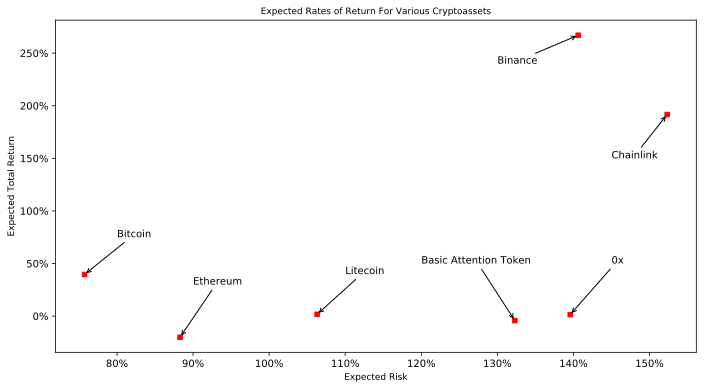

In [19]:
# plot frontier, max sharpe & min Volatility values with a scatterplot
ax = df.plot.scatter(x='Volatility', y='Returns', marker = 's', color='r', edgecolors='r', figsize=(11.5, 6))
plt.xlabel('Expected Risk', fontsize = 9)
plt.ylabel('Expected Total Return', fontsize = 9)
plt.title('Expected Rates of Return For Various Cryptoassets', fontsize = 9)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
#ax.set(xlim=(50, 140), ylim=(50, 300))

#https://matplotlib.org/3.1.1/tutorials/text/annotations.html

plt.annotate('Bitcoin', xy=(df.iloc[0]['Volatility'], df.iloc[0]['Returns']), xytext=(80, 75),
             arrowprops=dict(arrowstyle="->"))

plt.annotate('Ethereum', xy=(df.iloc[1]['Volatility'], df.iloc[1]['Returns']), xytext=(90, 30),
             arrowprops=dict(arrowstyle="->"))

plt.annotate('Litecoin', xy=(df.iloc[2]['Volatility'], df.iloc[2]['Returns']), xytext=(110, 40),
             arrowprops=dict(arrowstyle="->"))

plt.annotate('Binance', xy=(df.iloc[3]['Volatility'], df.iloc[3]['Returns']), xytext=(130, 240),
             arrowprops=dict(arrowstyle="->"))

plt.annotate('Chainlink', xy=(df.iloc[4]['Volatility'], df.iloc[4]['Returns']), xytext=(145, 150),
             arrowprops=dict(arrowstyle="->"))

plt.annotate('Basic Attention Token', xy=(df.iloc[5]['Volatility'], df.iloc[5]['Returns']), xytext=(120, 50),
             arrowprops=dict(arrowstyle="->"))

plt.annotate('0x', xy=(df.iloc[6]['Volatility'], df.iloc[6]['Returns']), xytext=(145, 50),
             arrowprops=dict(arrowstyle="->"))

plt.show()